In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
import zipfile

In [3]:
! pip install implicit >> None

In [4]:
! pip install lightfm >> None

In [5]:
with zipfile.ZipFile('/content/drive/MyDrive/data.zip') as zip_file:
  zip_file.extractall('/content')

dowload data

In [6]:
items = pd.read_csv('data/items.csv')
users = pd.read_csv('/content/data/users.csv')
interactions = pd.read_csv('/content/data/interactions.csv')

In [7]:
items.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [8]:
users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [9]:
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [10]:
interactions.columns = ['user_id', 'item_id', 'datetime', 'weight', 'watched_pct']

In [11]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int64  
 1   item_id      int64  
 2   datetime     object 
 3   weight       int64  
 4   watched_pct  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 208.9+ MB


In [12]:
interactions['datetime'] = pd.to_datetime(interactions['datetime'])

Prepare for validation. Create splitter

In [15]:
! pip install rectools >> None

In [17]:
! pip uninstall implicit

Found existing installation: implicit 0.4.4
Uninstalling implicit-0.4.4:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/implicit-0.4.4.dist-info/*
    /usr/local/lib/python3.8/dist-packages/implicit/*
Proceed (y/n)? y
  Successfully uninstalled implicit-0.4.4


In [18]:
! pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached implicit-0.6.2-cp38-cp38-manylinux2014_x86_64.whl (18.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rectools 0.3.0 requires implicit==0.4.4, but you have implicit 0.6.2 which is incompatible.


In [19]:
from rectools.model_selection import TimeRangeSplitter
from rectools.metrics import MAP, calc_metrics
from rectools.dataset import Interactions
from copy import deepcopy

In [20]:
n_folds = 3
unit = 'D'
n_units = 7
last_date = interactions['datetime'].max().normalize()

In [21]:
start_date = last_date - pd.Timedelta(n_folds * n_units - 1, unit=unit)
periods = n_folds + 1
freq = f"{n_units}{unit}"

In [22]:
date_range = pd.date_range(start=start_date, periods=periods, freq=freq, tz=last_date.tz)
date_range

DatetimeIndex(['2021-08-02', '2021-08-09', '2021-08-16', '2021-08-23'], dtype='datetime64[ns]', freq='7D')

In [23]:
inters = Interactions(interactions)

In [24]:
splitter = TimeRangeSplitter(
    date_range=date_range,
    filter_already_seen=True,
    filter_cold_items=True,
    filter_cold_users=True,
)

In [25]:
def make_splitter(inters):
  n_folds = 3
  unit = 'D'
  n_units = 7
  last_date = inters['datetime'].max().normalize()
  start_date = last_date - pd.Timedelta(n_folds * n_units - 1, unit=unit)
  periods = n_folds + 1
  freq = f"{n_units}{unit}"
  date_range = pd.date_range(start=start_date, periods=periods, freq=freq, tz=last_date.tz)

  splitter = TimeRangeSplitter(
    date_range=date_range,
    filter_already_seen=True,
    filter_cold_items=True,
    filter_cold_users=True,
    )
  return splitter

# Start to use models. LightFM

In [ ]:
from lightfm import LightFM
from lightfm.data import Dataset as LFMDataset

In [ ]:
warp_model = LightFM(
    learning_rate=0.01,
    loss='warp',
    no_components=64
)

In [ ]:
interactions.head()

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250.0,72.0
1,699317,1659,2021-05-29,8317.0,100.0
2,656683,7107,2021-05-09,10.0,0.0
3,864613,7638,2021-07-05,14483.0,100.0
4,964868,9506,2021-04-30,6725.0,100.0


In [ ]:
def get_n_recs_for_user(user_id, model, train_matrix, user2id, id2item, n=10):
  user_inner_id = user2id[user_id]
  scores = model.predict(
      user_ids=user_inner_id,
      item_ids=np.arange(train_matrix.shape[1]),
      num_threads=3,
  )

  user_watched_items = train_matrix.col[train_matrix.row == user_inner_id]
  scores[user_watched_items] = -np.inf

  recommended_item_inner_ids = np.argpartition(scores, -np.arange(n))[
      -n:
  ][::-1]
  recommended_item_ids = [id2item[x] for x in recommended_item_inner_ids]
  return recommended_item_ids

In [ ]:
def get_map(model, inters_dataset):
  splitter = make_splitter(inters_dataset.df)

  results = []
  for train_ids, test_ids, _ in splitter.split(inters_dataset):
    recommender = deepcopy(model)
    df_train = inters_dataset.df.iloc[train_ids]
    df_test = inters_dataset.df.iloc[test_ids][['user_id', 'item_id']]

    lfm_dataset = LFMDataset()
    lfm_dataset.fit(
        users=df_train['user_id'].values,
        items=df_train['item_id'].values,
    )

    train_matrix, _ = lfm_dataset.build_interactions(zip(*df_train[['user_id', 'item_id']].values.T))
    recommender.fit(
        interactions=train_matrix,
        epochs=10,
        num_threads=3
    )

    id_item_mapping = {v: k for k, v in lfm_dataset._item_id_mapping.items()}

    test_users = np.unique(df_test['user_id']) 
    recs = []
    for user in tqdm(test_users):
      rec = get_n_recs_for_user(
          user_id=user,
          model=recommender,
          train_matrix=train_matrix,
          user2id=lfm_dataset._user_id_mapping,
          id2item=id_item_mapping
          )
      rec = [[user, item, i] for i, item in enumerate(rec, start=1)]
      recs.extend(rec)

    recs = pd.DataFrame(recs, columns=['user_id', 'item_id', 'rank'])

    result = np.mean(MAP(10).calc_per_user(recs, df_test).values)
    results.append(result)
  return np.mean(results), np.std(results)

In [ ]:
get_map(warp_model, inters)

100%|██████████| 103511/103511 [18:00<00:00, 95.82it/s] 


(0.09325919364035083, 0.0037547727745730064)

Скор на валидации: 0.09, превосходит baselines в виде популярного значения

prediction

In [23]:
cold_rec  = interactions.item_id.value_counts().index[:10]

In [ ]:
def get_pred_rec(model, user_id, knowns, train_mat, user2id, id2item):
  if user_id not in knowns:
    return cold_rec.values.tolist()
  rec = get_n_recs_for_user(
          user_id=user_id,
          model=model,
          train_matrix=train_mat,
          user2id=user2id,
          id2item=id2item
          )
  return rec

In [ ]:
def make_prediction(file_name, model):
  known_users = np.unique(interactions.user_id.values)
  lfm_dataset = LFMDataset()
  lfm_dataset.fit(
      users=interactions['user_id'].values,
      items=interactions['item_id'].values,
  )

  train_matrix, _ = lfm_dataset.build_interactions(zip(*interactions[['user_id', 'item_id']].values.T))
  model.fit(
      interactions=train_matrix,
      epochs=10,
      num_threads=3
  )

  id_item_mapping = {v: k for k, v in lfm_dataset._item_id_mapping.items()}
  user2id = lfm_dataset._user_id_mapping
  submission = pd.read_csv('data/sample_submission.csv')
  users = submission.user_id
  submission['item_id'] = submission['user_id'].apply(lambda x: get_pred_rec(model, x, known_users, train_matrix, user2id, id_item_mapping))
  submission.to_csv(file_name, index=False)
  print('Task is completed')

Итоговый скор на сабмитте - 0,1034406152; что превосходит предыдущий результат бэйзлайна popular model

# Implicit

In [57]:
! pip uninstall implicit

Found existing installation: implicit 0.4.4
Uninstalling implicit-0.4.4:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/implicit-0.4.4.dist-info/*
    /usr/local/lib/python3.8/dist-packages/implicit/*
Proceed (y/n)? y
  Successfully uninstalled implicit-0.4.4


In [55]:
! pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
cold_rec  = interactions.item_id.value_counts().index[:10]

In [28]:
import implicit
from implicit.evaluation import mean_average_precision_at_k
from scipy.sparse import coo_matrix

In [29]:
import os
os.environ['MKL_NUM_THREADS'] = '1' #To avoid multithreading.
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [30]:
ALL_USERS = np.unique(interactions['user_id'])
ALL_ITEMS = np.unique(interactions['item_id'])

In [56]:
user_ids = dict(list(enumerate(ALL_USERS)))
item_ids = dict(list(enumerate(ALL_ITEMS)))

In [32]:
user_map = {u: uidx for uidx, u in user_ids.items()}
item_map = {i: iidx for iidx, i in item_ids.items()}

In [33]:
interactions['user_id_row_id'] = interactions['user_id'].map(user_map)
interactions['item_id_col_id'] = interactions['item_id'].map(item_map)

### ALS

In [36]:
als_model = implicit.als.AlternatingLeastSquares(factors=32, iterations=15)

Validation of model

In [34]:
def to_user_item_coo(df, weights=True):
    """ Turn a dataframe with transactions into a COO sparse items x users matrix"""
    row = df['user_id_row_id'].values
    col = df['item_id_col_id'].values
    if weights:
      data = df['weight'].values
    else:
      data = np.ones(df.shape[0])
    coo = coo_matrix((data, (row, col)), shape=(len(ALL_USERS), len(ALL_ITEMS)))
    return coo

In [38]:
inters = Interactions(interactions)

In [47]:
interactions.describe()

,user_id,item_id,weight,watched_pct,user_id_row_id,item_id_col_id
count,5.476251e+06,5.476251e+06,5.476251e+06,5.475423e+06,5.476251e+06,5.476251e+06
mean,5.491159e+05,8.485860e+03,8.295490e+03,4.637400e+01,4.812477e+05,8.059945e+03
std,3.166077e+05,4.740762e+03,4.856799e+04,4.191853e+01,2.776221e+05,4.501526e+03
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.750140e+05,4.326000e+03,3.710000e+02,4.000000e+00,2.408430e+05,4.111000e+03
50%,5.493640e+05,8.776000e+03,2.898000e+03,3.200000e+01,4.812170e+05,8.336000e+03
75%,8.227540e+05,1.254400e+04,7.116000e+03,1.000000e+02,7.212480e+05,1.190400e+04
max,1.097557e+06,1.651800e+04,8.041167e+07,1.000000e+02,9.621780e+05,1.570500e+04


In [39]:
def get_map_validate(model, inters_dataset):
  splitter = make_splitter(inters_dataset.df)

  results = []
  for train_ids, test_ids, _ in splitter.split(inters_dataset):
    recommender = deepcopy(model)
    df_train = inters_dataset.df.iloc[train_ids].reset_index()
    df_test = inters_dataset.df.iloc[test_ids].reset_index()

    coo_train = to_user_item_coo(df_train)
    coo_test = to_user_item_coo(df_test)

    csr_train = coo_train.tocsr()
    csr_test = coo_test.tocsr()

    recommender.fit(coo_train)

    map10 = mean_average_precision_at_k(recommender, csr_train, csr_test, K=10)
    results.append(map10)
  return np.mean(results)

In [43]:
get_map_validate(als_model, inters)

/usr/local/lib/python3.8/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.24909663200378418 seconds
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/98184 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.3204770088195801 seconds
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/103511 [00:00<?, ?it/s]

0.026165536095909214

На валидации качество низкое - 0.026165536095909214

In [44]:
coo_train = to_user_item_coo(interactions)
csr_train = coo_train.tocsr()

In [46]:
als_model = implicit.als.AlternatingLeastSquares(factors=32, iterations=15)

In [47]:
als_model.fit(coo_train)

/usr/local/lib/python3.8/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.5616588592529297 seconds
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

In [55]:
def submit(model, csr_train):
    preds = []
    batch_size = 2000
    to_generate = np.arange(len(ALL_USERS))
    for startidx in range(0, len(to_generate), batch_size):
        batch = to_generate[startidx : startidx + batch_size]
        ids, scores = model.recommend(batch, csr_train[batch], N=10, filter_already_liked_items=False)
        for i, userid in enumerate(batch):
            customer_id = user_ids[userid]
            user_items = ids[i]
            article_ids = [item_ids[item_id] for item_id in user_items]
            preds.append((customer_id, article_ids))

    df_preds = pd.DataFrame(preds, columns=['user_id', 'item_id'])
    
    display(df_preds.head())
    print(df_preds.shape)
    
    return df_preds

In [56]:
df_preds = submit(als_model, csr_train)

,user_id,item_id
0,0,"[15297, 9728, 12192, 7102, 9194, 3935, 12324, ..."
1,1,"[10440, 11640, 16509, 6626, 4495, 11863, 6443,..."
2,2,"[7571, 16166, 3182, 4436, 13018, 5411, 16270, ..."
3,3,"[2657, 3734, 4880, 9728, 10440, 142, 4151, 121..."
4,4,"[4436, 14317, 12995, 15464, 7102, 5693, 9728, ..."


(962179, 2)


In [59]:
submission = pd.read_csv('data/sample_submission.csv')

In [60]:
submission = submission.drop(columns=['item_id'])

In [62]:
submission = pd.merge(submission, df_preds, how='left', on='user_id')

In [66]:
for row in submission.loc[submission.item_id.isnull(), 'item_id'].index:
    submission.at[row, 'item_id'] = cold_rec.values.tolist()

In [67]:
submission.to_csv('als.csv', index=False)

Итоговый скор:  0,0612314983 , что уступает baselines

## Implicit KNN

In [27]:
from implicit.nearest_neighbours import CosineRecommender, TFIDFRecommender

In [118]:
inters = Interactions(interactions)

In [120]:
inters.df.shape

(5476251, 7)

In [35]:
def compute_map(df_true, df_pred):
    test_recs = df_true.set_index(['user_id', 'item_id']).join(df_pred.set_index(['user_id', 'item_id']))
    test_recs = test_recs.sort_values(by=['user_id', 'rank'])

    test_recs['users_item_count'] = test_recs.groupby(level='user_id')['rank'].transform(np.size)
    test_recs['reciprocal_rank'] = (1 / test_recs['rank']).fillna(0)
    test_recs['cumulative_rank'] = test_recs.groupby(level='user_id').cumcount() + 1
    test_recs['cumulative_rank'] = test_recs['cumulative_rank'] / test_recs['rank']
    
    users_count = test_recs.index.get_level_values('user_id').nunique()

    map_ = (test_recs["cumulative_rank"] / test_recs["users_item_count"]).sum() / users_count
    return map_

In [51]:
def generate_implicit_recs_mapper(model, train_matrix, N, user_mapping, item_inv_mapping):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.recommend(user_id, 
                               train_matrix, 
                               N=N, 
                               filter_already_liked_items=True)
        recs = recs[0]
        return [item_inv_mapping[item] for item in recs]
    return _recs_mapper

In [115]:
def get_map_knn(model, inter_data, n=10):
  splitter = make_splitter(inter_data.df)
  results = []
  for train_ids, test_ids, _ in splitter.split(inter_data):
    recommender = deepcopy(model)
    df_train = inter_data.df.iloc[train_ids]
    df_test = inter_data.df.iloc[test_ids]

    train_mat = to_user_item_coo(df_train).tocsr()
    model.fit(train_mat, show_progress=True) 

    mapper = generate_implicit_recs_mapper(model, train_mat, n, user_map, item_ids)

    recs = pd.DataFrame({
        'user_id': df_test['user_id'].unique()
    })
    recs['item_id'] = recs['user_id'].map(mapper)
    recs = recs.explode('item_id')
    recs['rank'] = recs.groupby('user_id').cumcount() + 1
    result = compute_map(df_test, recs)
    results.append(result)
  return np.mean(results)

In [121]:
cosine_model = CosineRecommender(K=10)

In [122]:
get_map_knn(cosine_model, inters)

/usr/local/lib/python3.8/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.033223867416381836 seconds
  warnings.warn(


  0%|          | 0/15706 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.03284406661987305 seconds
  warnings.warn(


  0%|          | 0/15706 [00:00<?, ?it/s]

0.05328387820641592

Скор 0.05328387820641592 , лучше чем у ALS, но показатели baselines также на побит

Submission

In [124]:
train_mat = to_user_item_coo(interactions)

In [125]:
cosine_model.fit(train_mat)

/usr/local/lib/python3.8/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.4511280059814453 seconds
  warnings.warn(


  0%|          | 0/15706 [00:00<?, ?it/s]

In [126]:
submission = pd.read_csv('data/sample_submission.csv')

In [127]:
recommend_per_user = generate_implicit_recs_mapper(cosine_model, train_mat, 10, user_map, item_ids)

In [128]:
def make_i2i_pred(user_id):
  if user_id not in ALL_USERS:
    return cold_rec.values.tolist()
  recs = recommend_per_user(user_id)
  return recs.tolist()

In [129]:
submission = submission.drop(columns=['item_id'])

In [ ]:
submission['item_id'] = submission['user_id'].apply(make_i2i_pred)

In [ ]:
submission.tocsv('item2item.csv', index=False)

Итоговый скор - 0,086669148, рекорд baselines не побит

Визуализация

In [133]:
validation_submit = {
    'model': [
        'lightFM_WARP',
        'implicit_ALS',
        'implicit_item2item',
        'lightFM_WARP',
        'implicit_ALS',
        'implicit_item2item'
    ],
    'score': [
        0.09325919364035083,
        0.026165536095909214,
        0.05328387820641592 ,
        0.1034406152,
        0.0612314983,
        0.086669148,
    ],
    'type': [
        'validation',
        'validation',
        'validation',
        'submit',
        'submit',
        'submit',
    ]
}

In [134]:
valudation_submit = pd.DataFrame(validation_submit)

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns

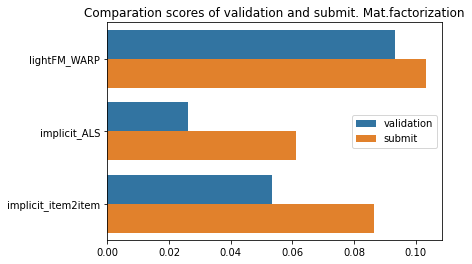

In [136]:
sns.barplot(data=validation_submit, x='score', y='model', hue='type')
plt.title('Comparation scores of validation and submit. Mat.factorization')
plt.savefig('validate_vs_submit_mat_factrization.png')